# Методы и алгоритмы анализа влияния различных факторов на рынок недвижимости

**Описание проекта**

> С появлением в России рыночных отношений возникла объективная необходимость независимой оценки рыночной стоимости недвижимости. Проблемы оценки недвижимости давно решаются зарубежными и сравнительно недавно - российскими учеными-экономистами.

> Существующие методики оценки объектов недвижимости основаны на категориях, отражающих развитые рыночные отношения, и практически «не работают» в условиях почти полного отсутствия рыночной информации, что порождает множество конфликтов между субъектами рыночных отношений. Об этом свидетельствует судебная практика оспаривания результатов проводимых оценок. 

> В связи с этим, для осуществления оценочной деятельности необходимо формирование новых подходов и методов оценки недвижимости, что будет способствовать справедливому формированию цен на недвижимость, информационной открытости локальных рынков недвижимости и, следовательно, тем самым улучшению инвестиционного климата в регионах.


Датасет загружен из платформы Kaggle. 

Ссылка: https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-2021

Описание данных:
- дата загрузки объявления
- цена на недвижимость
- этаж
- количество этажей в доме
- количество комнат
- площадь недвидимости
- площадь кухни
- широта
- долгота
- тип здания 
  - 0 - Не известно;
  - 1 - Другое;
  - 2 - Панельное;
  - 3 - Монолитное;
  - 4 - Кирпичное;
  - 5 - Блочное;
  - 6 - Деревенное.
- тип недвижимости
  - 0 - Вторичный рынок недвижимости; 
  - 2 - Новое здание.
- почтовый индекс
- идентификатор улицы
- номер региона
- идентификатор дома


## Предобработка данных

### Импортируем необходимые библиотеки и взглянем на данные

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer

from geopy.distance import geodesic

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

import catboost
from catboost import CatBoostRegressor, cv, Pool

#import lightgbm as lgb
#from lightgbm import LGBMRegressor

import time

import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('input_data.csv', sep=';')

In [3]:
data.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,30.3,0.0,56.780112,60.699355,0,2,620000.0,NaN,66,1632918.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,0,142701.0,242543.0,50,681306.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,2,353960.0,439378.0,23,1730985.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11358150 entries, 0 to 11358149
Data columns (total 15 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date           object 
 1   price          int64  
 2   level          int64  
 3   levels         int64  
 4   rooms          int64  
 5   area           float64
 6   kitchen_area   float64
 7   geo_lat        float64
 8   geo_lon        float64
 9   building_type  int64  
 10  object_type    int64  
 11  postal_code    float64
 12  street_id      float64
 13  id_region      int64  
 14  house_id       float64
dtypes: float64(7), int64(7), object(1)
memory usage: 1.3+ GB


Приведем названия столбцов к удобному виду:

In [5]:
data.columns

Index(['date', 'price', 'level', 'levels', 'rooms', 'area', 'kitchen_area',
       'geo_lat', 'geo_lon', 'building_type', 'object_type', 'postal_code',
       'street_id', 'id_region', 'house_id'],
      dtype='object')

In [6]:
data.columns = ['date', 'price', 'level', 'levels', 'rooms', 'area', 'kitchen_area',
       'latitude', 'longitude', 'building_type', 'object_type', 'postal_code',
       'street_id', 'region', 'house_id']

In [7]:
data['region'].value_counts()

77    1032600
72     865423
23     846948
78     765872
50     754267
       ...   
8        2498
6        1195
87        147
79         55
83         48
Name: region, Length: 86, dtype: int64

Исследовать будем город Белгород, поэтому сделаем срез с данными белгорода:

Отфильтруем сначала по региону, а потом по почтовым индексам:

In [8]:
data_bgd = data[data['region'] == 31]
data_bgd

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,0,0,308033.0,473680.0,31,2138731.0
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,4,0,308013.0,235193.0,31,2456500.0
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,2,0,308004.0,142358.0,31,2484431.0
420,2021-01-01,3700000,4,4,3,104.0,0.0,51.301583,37.897593,4,0,309511.0,301193.0,31,2005381.0
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,4,0,308002.0,549537.0,31,2818216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11355945,2021-12-31,4800000,3,9,4,82.1,11.0,51.310764,37.895455,0,0,309512.0,224650.0,31,2228997.0
11356042,2021-12-31,3370000,4,5,1,32.0,6.0,50.631864,36.583110,0,0,308023.0,497145.0,31,1159076.0
11357073,2021-12-31,9000000,7,9,3,104.0,13.0,50.567401,36.589064,0,0,308033.0,158492.0,31,1757293.0
11357641,2021-12-31,6700000,1,12,3,94.6,13.4,51.314745,37.914978,0,0,309503.0,157085.0,31,2663987.0


In [9]:
data_bgd = data_bgd[(data_bgd['postal_code'] < 308511) & (data_bgd['postal_code'] > 308000)]
data_bgd

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,0,0,308033.0,473680.0,31,2138731.0
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,4,0,308013.0,235193.0,31,2456500.0
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,2,0,308004.0,142358.0,31,2484431.0
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,4,0,308002.0,549537.0,31,2818216.0
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,5,2,308019.0,NaN,31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11352932,2021-12-31,5500000,8,10,2,51.7,9.0,50.564194,36.569256,0,0,308004.0,NaN,31,NaN
11354561,2021-12-31,4200000,6,12,1,39.6,8.3,50.584459,36.646547,0,0,308013.0,496646.0,31,639367.0
11356042,2021-12-31,3370000,4,5,1,32.0,6.0,50.631864,36.583110,0,0,308023.0,497145.0,31,1159076.0
11357073,2021-12-31,9000000,7,9,3,104.0,13.0,50.567401,36.589064,0,0,308033.0,158492.0,31,1757293.0


In [10]:
data_bgd['region'].value_counts()

31    63020
Name: region, dtype: int64

Расставим точки с объявлениями на карте чтобы убедиться в географии:

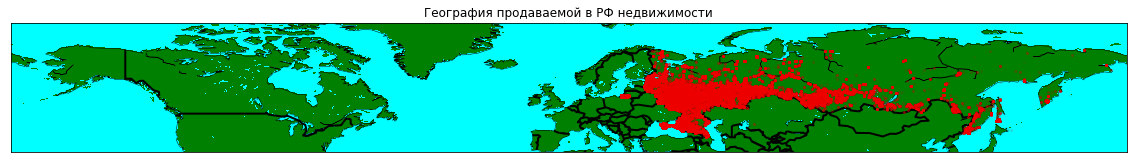

In [13]:
lat = data['latitude'].values
lon = data['longitude'].values

plt.figure(figsize=(20, 15))

m = Basemap(projection="mill"
            ,llcrnrlat=lat.min()-5
            ,urcrnrlat=lat.max()+5
            ,llcrnrlon=lon.min()-5
            ,urcrnrlon=lon.max()+5
            ,resolution='c'
            ,epsg=4269)
m.drawlsmask(land_color='green',ocean_color='aqua',lakes=True)
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=2) 


parallels = np.arange(0.,81,10.)
meridians = np.arange(0.,360.,10.)

# Pickup coordinates
m.plot(lon, lat, 'ro', markersize=2 ,alpha=.05)

plt.title("География продаваемой в РФ недвижимости")
plt.show()

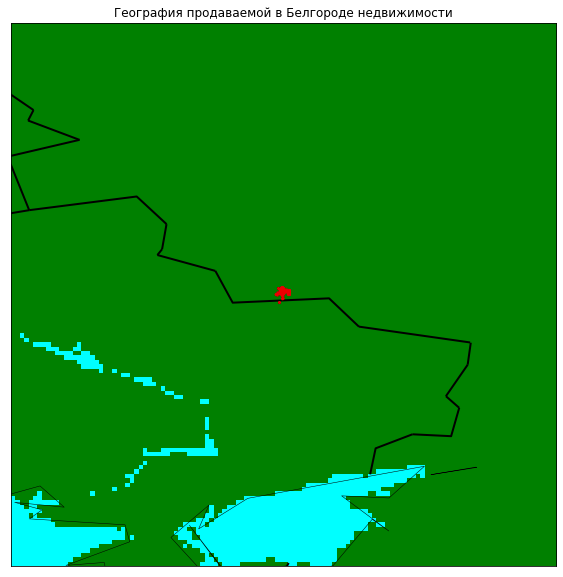

In [14]:
# read in data to use for plotted points
lat = data_bgd['latitude'].values
lon = data_bgd['longitude'].values

# Prepare basemap

plt.figure(figsize=(10,10))

m = Basemap(projection="mill"
            ,llcrnrlat=lat.min()-5
            ,urcrnrlat=lat.max()+5
            ,llcrnrlon=lon.min()-5
            ,urcrnrlon=lon.max()+5
            ,resolution='c'
            ,epsg=4269)
m.drawlsmask(land_color='green',ocean_color='aqua',lakes=True)
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=2) 


parallels = np.arange(0.,81,10.)
meridians = np.arange(0.,360.,10.)

# Pickup coordinates
m.plot(lon, lat, 'ro', markersize=2 ,alpha=.05)

plt.title("География продаваемой в Белгороде недвижимости")
plt.show()

Проверим данные на наличие пропусков:

In [11]:
data_bgd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63020 entries, 75 to 11358015
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           63020 non-null  object 
 1   price          63020 non-null  int64  
 2   level          63020 non-null  int64  
 3   levels         63020 non-null  int64  
 4   rooms          63020 non-null  int64  
 5   area           63020 non-null  float64
 6   kitchen_area   63020 non-null  float64
 7   latitude       63020 non-null  float64
 8   longitude      63020 non-null  float64
 9   building_type  63020 non-null  int64  
 10  object_type    63020 non-null  int64  
 11  postal_code    63020 non-null  float64
 12  street_id      39594 non-null  float64
 13  region         63020 non-null  int64  
 14  house_id       40067 non-null  float64
dtypes: float64(7), int64(7), object(1)
memory usage: 7.7+ MB


В целом, данные которые содержат полезную для исселования информацию - чистые. Пропуски присутствуют только в столбцах: street_id, house_id. 

Проверим данные на наличие дубликатов:

In [12]:
data_bgd.duplicated().sum()

1334

In [13]:
data_bgd.drop_duplicates(inplace=True)

In [14]:
data_bgd.duplicated().sum()

0

Для удобства анализа преобразуем тип недвижимости и дома к удобному формату.

- тип здания 
  - 0 - Не известно;
  - 1 - Другое;
  - 2 - Панельное;
  - 3 - Монолитное;
  - 4 - Кирпичное;
  - 5 - Блочное;
  - 6 - Деревенное.
- тип недвижимости
  - 0 - Вторичный рынок недвижимости; 
  - 2 - Новое здание.

In [15]:
def change_type(row):
  if row['building_type'] == 0:
    row['building_type'] = 'Не известно'
  if row['building_type'] == 1:
    row['building_type'] = 'другое'
  if row['building_type'] == 2:
    row['building_type'] = 'панельный'
  if row['building_type'] == 3:
    row['building_type'] = 'монолитный'
  if row['building_type'] == 4:
    row['building_type'] = 'кирпичный'
  if row['building_type'] == 5:
    row['building_type'] = 'блочный'  
  if row['building_type'] == 6:
    row['building_type'] = 'деревянный'  

  if row['object_type'] == 0:
    row['object_type'] = 'новостройка'
  if row['object_type'] == 2:
    row['object_type'] = 'вторичное'

  return row

In [16]:
data_bgd = data_bgd.apply(change_type, axis=1)
data_bgd.head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,Не известно,новостройка,308033.0,473680.0,31,2138731.0
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,кирпичный,новостройка,308013.0,235193.0,31,2456500.0
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,панельный,новостройка,308004.0,142358.0,31,2484431.0
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,кирпичный,новостройка,308002.0,549537.0,31,2818216.0
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,блочный,вторичное,308019.0,NaN,31,NaN


Преобразуем теперь столбец с датой к типу datetime:

In [17]:
data_bgd['date'] = pd.to_datetime(data_bgd['date'])
data_bgd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61686 entries, 75 to 11358015
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           61686 non-null  datetime64[ns]
 1   price          61686 non-null  int64         
 2   level          61686 non-null  int64         
 3   levels         61686 non-null  int64         
 4   rooms          61686 non-null  int64         
 5   area           61686 non-null  float64       
 6   kitchen_area   61686 non-null  float64       
 7   latitude       61686 non-null  float64       
 8   longitude      61686 non-null  float64       
 9   building_type  61686 non-null  object        
 10  object_type    61686 non-null  object        
 11  postal_code    61686 non-null  float64       
 12  street_id      38639 non-null  float64       
 13  region         61686 non-null  int64         
 14  house_id       39111 non-null  float64       
dtypes: datetime64[n

### Проверим данные на их адекватность:

In [18]:
data_bgd.describe()

,price,level,levels,rooms,area,kitchen_area,latitude,longitude,postal_code,street_id,region,house_id
count,6.168600e+04,61686.000000,61686.000000,61686.000000,61686.000000,61686.000000,61686.000000,61686.000000,61686.000000,38639.000000,61686.0,3.911100e+04
mean,4.517661e+06,4.921943,8.604724,2.009305,55.154680,-3.156199,50.580924,36.581567,308062.206741,341525.992003,31.0,1.723266e+06
std,3.986335e+07,3.325943,3.793582,0.986302,22.964643,35.104332,0.027059,0.034789,139.518903,143015.729768,0.0,6.298073e+05
min,0.000000e+00,0.000000,0.000000,-1.000000,10.000000,-100.000000,50.369235,36.434085,308001.000000,119015.000000,31.0,5.901680e+05
25%,3.250000e+06,2.000000,5.000000,1.000000,39.000000,6.000000,50.561735,36.565834,308009.000000,211710.000000,31.0,1.215513e+06
50%,3.990000e+06,4.000000,9.000000,2.000000,50.000000,8.600000,50.578893,36.576659,308023.000000,335161.000000,31.0,1.745319e+06
75%,4.950000e+06,7.000000,10.000000,3.000000,65.000000,10.000000,50.599632,36.589424,308031.000000,468249.000000,31.0,2.251688e+06
max,8.999999e+09,19.000000,25.000000,8.000000,375.000000,96.000000,50.655608,36.761990,308510.000000,586672.000000,31.0,2.837955e+06


Из числового описания данных видно что есть объявления с отрицательной площадью кухни, отрицательным числом комнат. Также есть данные с аномально высокой ценой. Это необходимо проверить:

In [19]:
data_bgd[data_bgd['rooms'] < 0].head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id
19560,2021-01-03,6850000,7,13,-1,51.4,9.0,50.589577,36.587523,Не известно,новостройка,308009.0,NaN,31,NaN
21065,2021-01-03,3200000,4,4,-1,32.0,6.0,50.601341,36.582249,кирпичный,новостройка,308009.0,335161.0,31,1336231.0
76435,2021-01-08,3200000,4,4,-1,33.0,7.0,50.601341,36.582249,кирпичный,новостройка,308009.0,335161.0,31,1336231.0
110494,2021-01-11,2450000,2,5,-1,27.0,11.0,50.597647,36.585665,Не известно,новостройка,308015.0,356140.0,31,1650682.0
112567,2021-01-11,5400000,12,16,-1,45.0,9.0,50.599947,36.603203,Не известно,новостройка,308001.0,211710.0,31,2023312.0


In [20]:
data_bgd[data_bgd['rooms'] < 0]['rooms'].value_counts()

-1    631
Name: rooms, dtype: int64

In [21]:
data_bgd[data_bgd['rooms'] < 0].describe()

,price,level,levels,rooms,area,kitchen_area,latitude,longitude,postal_code,street_id,region,house_id
count,6.310000e+02,631.000000,631.000000,631.0,631.000000,631.000000,631.000000,631.000000,631.000000,407.000000,631.0,4.080000e+02
mean,3.906917e+06,5.213946,9.438986,-1.0,40.412694,-19.059033,50.590583,36.572562,308049.652932,368201.449631,31.0,1.762977e+06
std,2.227555e+06,3.455412,4.648161,0.0,25.991982,46.340257,0.020889,0.029545,126.536456,121939.726515,0.0,6.058708e+05
min,0.000000e+00,1.000000,1.000000,-1.0,12.000000,-100.000000,50.524140,36.464710,308001.000000,131946.000000,31.0,6.471920e+05
25%,2.750000e+06,3.000000,5.000000,-1.0,27.000000,0.000000,50.580411,36.559760,308009.000000,281771.000000,31.0,1.218703e+06
50%,3.600000e+06,5.000000,9.000000,-1.0,34.000000,5.000000,50.597768,36.575987,308015.000000,356140.000000,31.0,1.780039e+06
75%,4.500000e+06,7.000000,14.000000,-1.0,47.000000,9.000000,50.603374,36.587423,308019.000000,468249.000000,31.0,2.261815e+06
max,1.760000e+07,19.000000,22.000000,-1.0,261.100000,39.000000,50.638290,36.689642,308510.000000,586672.000000,31.0,2.813101e+06


Исходя из числового описания можно сделать вывод что данные нормальные и при их выгрузке произошла ошибка. Прменим метод abs:

In [22]:
data_bgd['rooms'] = data_bgd['rooms'].apply(np.abs)
data_bgd[data_bgd['rooms'] < 0]['rooms'].count()

0

Теперь проверим площади кухонь:

In [23]:
data_bgd[data_bgd['kitchen_area'] < 0].head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id
3180,2021-01-01,4800000,12,15,3,86.6,-100.0,50.556562,36.566085,кирпичный,новостройка,308036.0,NaN,31,NaN
11509,2021-01-02,13750000,14,16,3,250.0,-100.0,50.610266,36.585398,монолитный,новостройка,308014.0,497145.0,31,790765.0
12789,2021-01-02,2900000,4,5,1,30.5,-100.0,50.601651,36.579722,кирпичный,новостройка,308009.0,335161.0,31,900143.0
33037,2021-01-04,3600000,2,2,2,46.2,-100.0,50.531538,36.500306,блочный,новостройка,308501.0,542550.0,31,2168935.0
45549,2021-01-05,3800000,1,6,3,72.0,-100.0,50.540198,36.575437,панельный,новостройка,308501.0,276857.0,31,1297792.0


In [24]:
data_bgd[data_bgd['kitchen_area'] < 0]['kitchen_area'].value_counts()

-100.0    7059
Name: kitchen_area, dtype: int64

В этом случае ситуация сложнее. Данные составляют 10% от всей выборки и они явно ошибочные. Мы можем либо удалить эти данные и потерять часть информации либо заменить эти данные на что-то определенное. Поскольку перед нами стоит задача регрессии, а этот признак числовой, то лучше избавиться от этих строк вообще.

In [25]:
data_bgd = data_bgd[data_bgd['kitchen_area'] > 0]
data_bgd.shape

(53303, 15)

Проверим цены в объявлениях на аномалии:

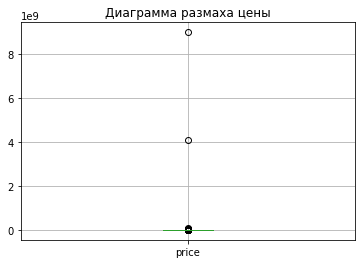

In [26]:
data_bgd.boxplot('price')
plt.title('Диаграмма размаха цены')
plt.show()

Из диаграммы размаха видно что есть аномально большие цены. Найдем эти объявления:

In [27]:
data_bgd[data_bgd['price'] > 100000000]

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id
6947635,2021-08-17,4100000000,8,9,2,44.7,6.3,50.570553,36.584736,Не известно,новостройка,308033.0,NaN,31,NaN
7182829,2021-08-24,8999999488,10,10,3,83.6,10.9,50.595737,36.587290,Не известно,новостройка,308009.0,267556.0,31,768483.0


Сразу видно что это плохие данные и их необходимо удалить:

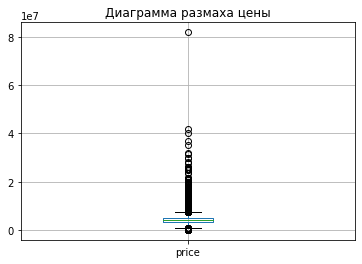

In [28]:
data_bgd = data_bgd[data_bgd['price'] < 100000000]
data_bgd.boxplot('price')
plt.title('Диаграмма размаха цены')
plt.show()

In [29]:
data_bgd[data_bgd['price'] > 80000000]

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id
9116446,2021-10-20,82000000,3,9,2,66.0,10.0,50.606399,36.582213,Не известно,новостройка,308002.0,320307.0,31,1307129.0


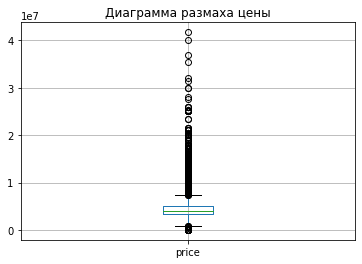

In [30]:
data_bgd = data_bgd[data_bgd['price'] < 80000000]
data_bgd.boxplot('price')
plt.title('Диаграмма размаха цены')
plt.show()

### Удалим ненужные переменные

In [31]:
del data

## Feature Engineering

Также для анализа и моделирования будет хорошо, если мы добавим дополнительные признаки. Например, цена за квадратный метр, отношение площади кухни к общей площади недвижимости, расстояние до центра города, месяц продажи, день недели.

### Цена за квадратный метр

In [32]:
data_bgd.head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,Не известно,новостройка,308033.0,473680.0,31,2138731.0
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,кирпичный,новостройка,308013.0,235193.0,31,2456500.0
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,панельный,новостройка,308004.0,142358.0,31,2484431.0
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,кирпичный,новостройка,308002.0,549537.0,31,2818216.0
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,блочный,вторичное,308019.0,NaN,31,NaN


In [33]:
data_bgd['price_per_meter'] = data_bgd['price'] / data_bgd['area']
data_bgd.head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id,price_per_meter
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,Не известно,новостройка,308033.0,473680.0,31,2138731.0,64666.666667
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,кирпичный,новостройка,308013.0,235193.0,31,2456500.0,60658.578856
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,панельный,новостройка,308004.0,142358.0,31,2484431.0,77450.980392
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,кирпичный,новостройка,308002.0,549537.0,31,2818216.0,59649.122807
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,блочный,вторичное,308019.0,NaN,31,NaN,43921.052632


### Отношение площади кухни к общей

In [34]:
data_bgd['ratio_kitchen_total_area'] = data_bgd['kitchen_area'] / data_bgd['area']
data_bgd.head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id,price_per_meter,ratio_kitchen_total_area
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,Не известно,новостройка,308033.0,473680.0,31,2138731.0,64666.666667,0.158333
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,кирпичный,новостройка,308013.0,235193.0,31,2456500.0,60658.578856,0.173310
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,панельный,новостройка,308004.0,142358.0,31,2484431.0,77450.980392,0.176471
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,кирпичный,новостройка,308002.0,549537.0,31,2818216.0,59649.122807,0.157895
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,блочный,вторичное,308019.0,NaN,31,NaN,43921.052632,0.150877


### Расстояние до центра

Определим центр города. В Белгороде это соборная площадь. Найдем широту и долготу этого объекта, а далее будем искать расстояния от объектов недвижимости до центра.

In [35]:
def calculate_distance(row):
  latitude_center_bgd = 50.595511 
  longitute_center_bgd = 36.587313
  center = (longitute_center_bgd, latitude_center_bgd)
  buf = (row['longitude'], row['latitude'])
  distance = geodesic(center, buf).km

  return distance

In [36]:
data_bgd['distance_to_center'] = data_bgd.apply(calculate_distance, axis=1)
data_bgd.head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id,price_per_meter,ratio_kitchen_total_area,distance_to_center
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,Не известно,новостройка,308033.0,473680.0,31,2138731.0,64666.666667,0.158333,2.604918
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,кирпичный,новостройка,308013.0,235193.0,31,2456500.0,60658.578856,0.173310,8.200197
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,панельный,новостройка,308004.0,142358.0,31,2484431.0,77450.980392,0.176471,3.797638
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,кирпичный,новостройка,308002.0,549537.0,31,2818216.0,59649.122807,0.157895,1.895039
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,блочный,вторичное,308019.0,NaN,31,NaN,43921.052632,0.150877,3.535620


Округлим расстояние до километров:

In [37]:
data_bgd['round_distance_to_center'] = data_bgd['distance_to_center'].apply(round)
data_bgd.head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id,price_per_meter,ratio_kitchen_total_area,distance_to_center,round_distance_to_center
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,Не известно,новостройка,308033.0,473680.0,31,2138731.0,64666.666667,0.158333,2.604918,3
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,кирпичный,новостройка,308013.0,235193.0,31,2456500.0,60658.578856,0.173310,8.200197,8
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,панельный,новостройка,308004.0,142358.0,31,2484431.0,77450.980392,0.176471,3.797638,4
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,кирпичный,новостройка,308002.0,549537.0,31,2818216.0,59649.122807,0.157895,1.895039,2
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,блочный,вторичное,308019.0,NaN,31,NaN,43921.052632,0.150877,3.535620,4


### Месяц продажи и день недели

In [38]:
data_bgd['month_of_sale'] = data_bgd['date'].dt.month
data_bgd.head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,object_type,postal_code,street_id,region,house_id,price_per_meter,ratio_kitchen_total_area,distance_to_center,round_distance_to_center,month_of_sale
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,Не известно,новостройка,308033.0,473680.0,31,2138731.0,64666.666667,0.158333,2.604918,3,1
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,кирпичный,новостройка,308013.0,235193.0,31,2456500.0,60658.578856,0.173310,8.200197,8,1
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,панельный,новостройка,308004.0,142358.0,31,2484431.0,77450.980392,0.176471,3.797638,4,1
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,кирпичный,новостройка,308002.0,549537.0,31,2818216.0,59649.122807,0.157895,1.895039,2,1
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,блочный,вторичное,308019.0,NaN,31,NaN,43921.052632,0.150877,3.535620,4,1


In [39]:
data_bgd['day_of_week'] = data_bgd['date'].dt.day_of_week
data_bgd.head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,...,postal_code,street_id,region,house_id,price_per_meter,ratio_kitchen_total_area,distance_to_center,round_distance_to_center,month_of_sale,day_of_week
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,Не известно,...,308033.0,473680.0,31,2138731.0,64666.666667,0.158333,2.604918,3,1,4
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,кирпичный,...,308013.0,235193.0,31,2456500.0,60658.578856,0.173310,8.200197,8,1,4
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,панельный,...,308004.0,142358.0,31,2484431.0,77450.980392,0.176471,3.797638,4,1,4
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,кирпичный,...,308002.0,549537.0,31,2818216.0,59649.122807,0.157895,1.895039,2,1,4
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,блочный,...,308019.0,NaN,31,NaN,43921.052632,0.150877,3.535620,4,1,4


## Исследовательский анализ данных

### Изучим следующие параметры: площадь, цена, число комнат. Построим гистограммы для каждого параметра

In [40]:
data_bgd.head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,...,postal_code,street_id,region,house_id,price_per_meter,ratio_kitchen_total_area,distance_to_center,round_distance_to_center,month_of_sale,day_of_week
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,Не известно,...,308033.0,473680.0,31,2138731.0,64666.666667,0.158333,2.604918,3,1,4
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,кирпичный,...,308013.0,235193.0,31,2456500.0,60658.578856,0.173310,8.200197,8,1,4
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,панельный,...,308004.0,142358.0,31,2484431.0,77450.980392,0.176471,3.797638,4,1,4
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,кирпичный,...,308002.0,549537.0,31,2818216.0,59649.122807,0.157895,1.895039,2,1,4
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,блочный,...,308019.0,NaN,31,NaN,43921.052632,0.150877,3.535620,4,1,4


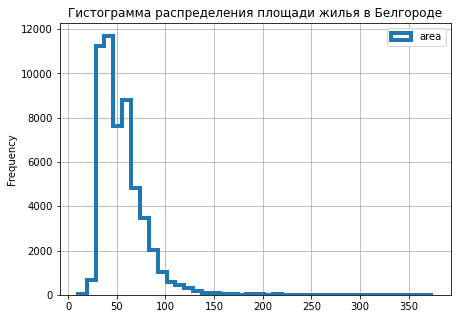

In [41]:
data_bgd.plot(kind='hist', y='area', histtype='step', bins=40, linewidth=4, grid=True, legend=True, figsize=(7,5))
plt.title('Гистограмма распределения площади жилья в Белгороде')
plt.show()

In [42]:
data_bgd['area'].describe()

count    53300.000000
mean        54.944802
std         22.394394
min         10.000000
25%         39.000000
50%         50.000000
75%         64.500000
max        375.000000
Name: area, dtype: float64

Из гистограммы и числового описания данных видно, что в Белгороде есть квартиры с площадью более 300 квадратных метров.

In [43]:
data_bgd[data_bgd['area'] > 300]

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,...,postal_code,street_id,region,house_id,price_per_meter,ratio_kitchen_total_area,distance_to_center,round_distance_to_center,month_of_sale,day_of_week
390336,2021-01-24,15900000,17,17,5,360.0,30.0,50.610266,36.585398,монолитный,...,308014.0,497145.0,31,790765.0,44166.666667,0.083333,1.337456,1,1,6
7678975,2021-09-07,3200000,7,9,1,312.0,7.3,50.564652,36.561661,Не известно,...,308004.0,158492.0,31,2128056.0,10256.410256,0.023397,3.966371,4,9,1
8586335,2021-10-04,3800000,5,10,1,375.0,9.0,50.567485,36.578559,Не известно,...,308033.0,158492.0,31,1740349.0,10133.333333,0.024000,2.689789,3,10,0
11100798,2021-12-20,15500000,17,17,5,356.0,25.0,50.595128,36.572122,Не известно,...,308015.0,NaN,31,NaN,43539.325843,0.070225,1.686090,2,12,0
11239468,2021-12-24,15500000,17,17,5,356.0,30.0,50.595128,36.572122,Не известно,...,308015.0,NaN,31,NaN,43539.325843,0.084270,1.686090,2,12,4


Таких объявлений оказалось всего 5. И двое из них вызывают некоторые вопросы. Во втором и третьем объявлении есть сильно несоответствие площади квартиры и цены. Их лучше удалить.

In [44]:
data_bgd = data_bgd.drop(index=[7678975, 8586335])
data_bgd[data_bgd['area'] > 300]

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,...,postal_code,street_id,region,house_id,price_per_meter,ratio_kitchen_total_area,distance_to_center,round_distance_to_center,month_of_sale,day_of_week
390336,2021-01-24,15900000,17,17,5,360.0,30.0,50.610266,36.585398,монолитный,...,308014.0,497145.0,31,790765.0,44166.666667,0.083333,1.337456,1,1,6
11100798,2021-12-20,15500000,17,17,5,356.0,25.0,50.595128,36.572122,Не известно,...,308015.0,NaN,31,NaN,43539.325843,0.070225,1.686090,2,12,0
11239468,2021-12-24,15500000,17,17,5,356.0,30.0,50.595128,36.572122,Не известно,...,308015.0,NaN,31,NaN,43539.325843,0.084270,1.686090,2,12,4


Построим теперь гистограмму распределение цен на жилье:

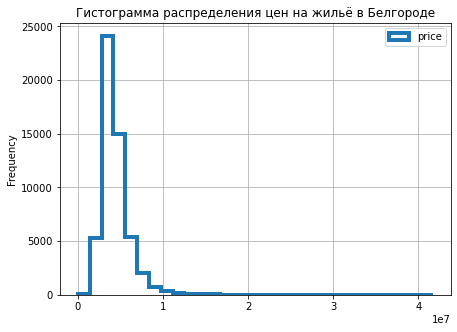

In [45]:
data_bgd.plot(kind='hist', y='price', histtype='step', bins=30, linewidth=4, grid=True, figsize=(7,5))
plt.title('Гистограмма распределения цен на жильё в Белгороде')
plt.show()

In [46]:
data_bgd['price'].describe()

count    5.329800e+04
mean     4.335441e+06
std      1.744356e+06
min      0.000000e+00
25%      3.280000e+06
50%      4.000000e+06
75%      4.950000e+06
max      4.170000e+07
Name: price, dtype: float64

In [47]:
data_bgd[data_bgd['price'] > 20000000]['price'].count()

33

In [48]:
data_bgd[data_bgd['price'] > 30000000]['price'].count()

6

In [49]:
data_bgd[data_bgd['price'] > 40000000]['price'].count()

1

In [50]:
data_bgd[data_bgd['price'] > 30000000]

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,...,postal_code,street_id,region,house_id,price_per_meter,ratio_kitchen_total_area,distance_to_center,round_distance_to_center,month_of_sale,day_of_week
5191453,2021-06-29,41700000,2,8,1,39.9,11.0,50.580162,36.569378,панельный,...,308024.0,142358.0,31,2674573.0,1.045113e+06,0.275689,2.418337,2,6,1
6470714,2021-08-03,37000000,16,17,6,255.0,25.0,50.601931,36.595961,Не известно,...,308001.0,245283.0,31,1637065.0,1.450980e+05,0.098039,1.118490,1,8,1
6800214,2021-08-12,40000000,11,11,3,270.0,22.0,50.579524,36.586211,другое,...,308012.0,316154.0,31,659516.0,1.481481e+05,0.081481,1.435935,1,8,3
8280989,2021-09-25,35400000,9,16,3,132.3,30.0,50.582970,36.576640,Не известно,...,308027.0,NaN,31,NaN,2.675737e+05,0.226757,1.631713,2,9,5
9018013,2021-10-17,31500000,11,12,4,270.0,30.0,50.584915,36.582821,другое,...,308009.0,NaN,31,NaN,1.166667e+05,0.111111,1.071303,1,10,6
9770924,2021-11-09,32000000,15,16,5,250.0,30.0,50.595169,36.581135,Не известно,...,308009.0,536910.0,31,936572.0,1.280000e+05,0.120000,0.686233,1,11,1


В этом срезе все объявления кроме первого в целом выглядят правдоподобно. Первое удалим:

In [51]:
data_bgd = data_bgd.drop(index=[5191453])

В целом из анализа гистограммы и числового описания можно сделать следующие выводы:
- в среднем жилье в Белгороде стоит 4 млн рублей
- есть много объектов стоимостью выше 10 млн рублей
- всего пара дестков объектов стоимостью выше 20 млн рублей

Построим теперь гистограмму распределения числа комнат в недвижимости Белгорода:

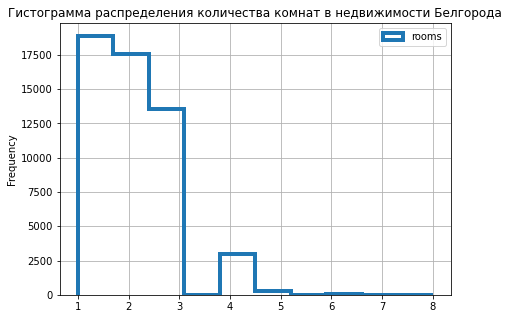

In [52]:
data_bgd.plot(kind='hist', y='rooms', histtype='step', bins=10, linewidth=4, grid=True, figsize=(7,5))
plt.title('Гистограмма распределения количества комнат в недвижимости Белгорода')
plt.show()

In [53]:
data_bgd['rooms'].describe()

count    53297.000000
mean         2.029626
std          0.941554
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

Исходя из гистограммы и числового описания данных можно сделать вывод о том, что в основном вся недвижимость Белгорода - это квартиры от 1 до 3-х комнат. Есть некоторая доля 4-х комнатных квартир и даже есть квартиры с 8 комнатами.

### Какие факторы больше всего влияют на стоимость квартиры? Изучим, зависит ли цена от площади, числа комнат, удалённости от центра. Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучим зависимость от даты размещения: дня недели, месяца.

**Изучим, зависит ли цена от площади, числа комнат, удалённости от центра.**

Возьмем срез с необходимыми нам величинами:

In [54]:
data_slice = data_bgd[['price', 'area', 'rooms', 'distance_to_center']]
data_slice.head()

,price,area,rooms,distance_to_center
75,3880000,60.0,2,2.604918
292,3500000,57.7,2,8.200197
367,3950000,51.0,2,3.797638
1148,3400000,57.0,3,1.895039
1777,5007000,114.0,3,3.535620


Построим матрицу диаграмм рассеяния:

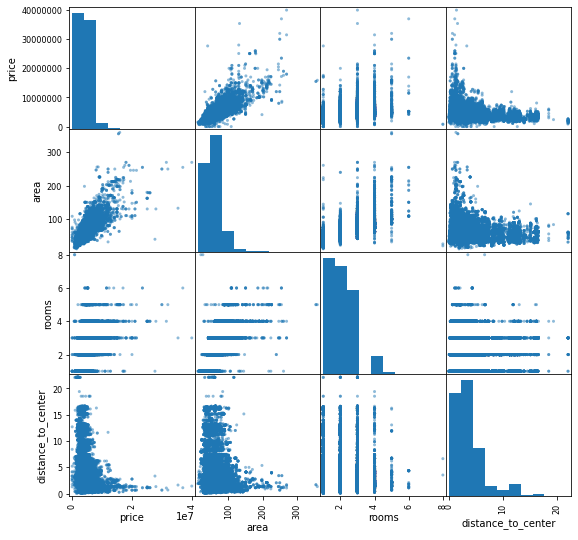

In [55]:
pd.plotting.scatter_matrix(data_slice, figsize=(9,9))
plt.show()

Выведем еще матрицу корреляции велечин:

In [56]:
data_slice.corr()

,price,area,rooms,distance_to_center
price,1.000000,0.785956,0.497770,-0.240242
area,0.785956,1.000000,0.756742,-0.120836
rooms,0.497770,0.756742,1.000000,-0.107601
distance_to_center,-0.240242,-0.120836,-0.107601,1.000000


**Вывод**

По матрице корреляции и по матрице диаграмм рассеяния видно что есть прямая зависимость между площадью и ценой, также присутствуют хоть и небольшая но прямая взаимосвязь между количеством комнат и ценой, а вот удаленность от центра влияет на цену лишь на значениях до 8км, что видно на графике между ценой и расстоянием.

**Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом.**

Категоризируем этажи недвижимости:

In [57]:
def category_level(row):
    if row['level'] == 1:
        return 'первый'
    if row['levels'] == row['level']:
        return 'последний'
    else:
        return 'другой'
    
data_bgd['category_level'] = data_bgd.apply(category_level, axis=1)
data_bgd.head()

,date,price,level,levels,rooms,area,kitchen_area,latitude,longitude,building_type,...,street_id,region,house_id,price_per_meter,ratio_kitchen_total_area,distance_to_center,round_distance_to_center,month_of_sale,day_of_week,category_level
75,2021-01-01,3880000,1,9,2,60.0,9.5,50.569676,36.576500,Не известно,...,473680.0,31,2138731.0,64666.666667,0.158333,2.604918,3,1,4,первый
292,2021-01-01,3500000,1,4,2,57.7,10.0,50.582151,36.660419,кирпичный,...,235193.0,31,2456500.0,60658.578856,0.173310,8.200197,8,1,4,первый
367,2021-01-01,3950000,1,9,2,51.0,9.0,50.555684,36.575505,панельный,...,142358.0,31,2484431.0,77450.980392,0.176471,3.797638,4,1,4,первый
1148,2021-01-01,3400000,1,5,3,57.0,9.0,50.612312,36.576919,кирпичный,...,549537.0,31,2818216.0,59649.122807,0.157895,1.895039,2,1,4,первый
1777,2021-01-01,5007000,9,16,3,114.0,17.2,50.572646,36.561332,блочный,...,NaN,31,NaN,43921.052632,0.150877,3.535620,4,1,4,другой


In [58]:
data_bgd.pivot_table(index='category_level', values='price', aggfunc=['mean', 'median'])

,mean,median
,price,price
category_level,,
другой,4.557464e+06,4200000
первый,3.753458e+06,3600000
последний,3.888885e+06,3600000


**Вывод**

Как и ожидалось, самые дешевый квартиры на первом этаже, средние цены имеют квартиры на последних этажах, а самые дорогие квартиры между ними.

**Изучим зависимость цены от даты размещения: дня недели, месяца**

In [59]:
data_bgd.pivot_table(index='day_of_week', values='price', aggfunc=['mean', 'median'])

,mean,median
,price,price
day_of_week,,
0,4.315808e+06,3950000
1,4.332041e+06,4000000
2,4.340367e+06,4000000
3,4.356027e+06,4000000
4,4.359225e+06,3990000
5,4.306356e+06,3970000
6,4.319593e+06,3964000


Цена в основном ниже в начале недели и к пятнице растет.

In [60]:
data_bgd.pivot_table(index='month_of_sale', values='price', aggfunc=['mean', 'median'])

,mean,median
,price,price
month_of_sale,,
1,4.113352e+06,3770000
2,4.119312e+06,3800000
3,4.018506e+06,3770000
4,4.126515e+06,3800000
5,4.176718e+06,3860000
6,4.199727e+06,3850000
7,4.254155e+06,3900000
8,4.328807e+06,3950000


Поскольку данные лишь за год мы не можем достоверно судить о сезонности, но по таблице хорошо видно что цены на недвижимость в 2021 году равномерно росли в течение всего года.

Построим график изменения средней цены на недвижимость в Белгороде за год:

In [61]:
data_bgd_grouped = data_bgd.groupby('month_of_sale')['price'].mean()

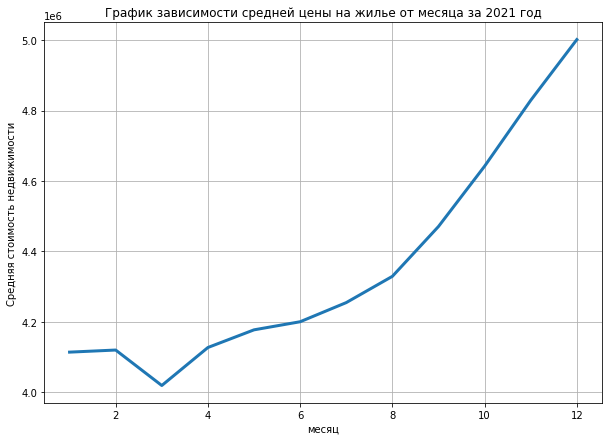

In [62]:
data_bgd_grouped.plot(grid=True, linewidth=3, figsize=(10,7), xlabel='месяц', ylabel='Средняя стоимость недвижимости')
plt.title('График зависимости средней цены на жилье от месяца за 2021 год')
plt.show()

Из данных и графика ярко выражен рост стоимости на недвижимость в Белгороде за год. Попробуем выяснить с чем связан такой быстрый рост. Можно предположить, что цены менялись из за изменения курса валют. Или изменение цен может быть связано с уменьшением заболеваемости населения коронавирусом.

Проверим эти предположения:

In [64]:
data_rub = pd.read_csv('USD_RUB.csv', decimal=',')
data_rub.head()

,Дата,Цена,Откр.,Макс.,Мин.,Изм. %
0,30.12.2021,74.6539,74.0000,75.1295,74.0000,"0,88%"
1,29.12.2021,74.0000,73.7359,74.1919,73.5559,"0,36%"
2,28.12.2021,73.7359,73.4634,73.8769,73.3407,"0,37%"
3,27.12.2021,73.4634,73.6673,73.6684,73.1070,"-0,28%"
4,24.12.2021,73.6673,73.3072,73.7286,73.1447,"0,49%"


In [65]:
data_rub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Дата    255 non-null    object 
 1   Цена    255 non-null    float64
 2   Откр.   255 non-null    float64
 3   Макс.   255 non-null    float64
 4   Мин.    255 non-null    float64
 5   Изм. %  255 non-null    object 
dtypes: float64(4), object(2)
memory usage: 12.1+ KB


Оставим только интересующие нас столбцы:

In [66]:
data_rub.columns

Index(['Дата', 'Цена', 'Откр.', 'Макс.', 'Мин.', 'Изм. %'], dtype='object')

In [67]:
data_rub = data_rub.drop(['Откр.', 'Макс.', 'Мин.', 'Изм. %'], axis=1)

In [68]:
data_rub['Дата'] = pd.to_datetime(data_rub['Дата'])

In [69]:
data_rub['месяц'] = data_rub['Дата'].dt.month

In [70]:
data_rub.head()

,Дата,Цена,месяц
0,2021-12-30,74.6539,12
1,2021-12-29,74.0000,12
2,2021-12-28,73.7359,12
3,2021-12-27,73.4634,12
4,2021-12-24,73.6673,12


In [71]:
data_rub_grouped = data_rub.groupby('месяц')['Цена'].mean()
data_rub_grouped

месяц
1     74.270468
2     73.896332
3     74.460285
4     75.054233
5     73.699350
6     73.157614
7     73.894357
8     73.675895
9     73.142817
10    71.683205
11    73.627285
12    73.872570
Name: Цена, dtype: float64

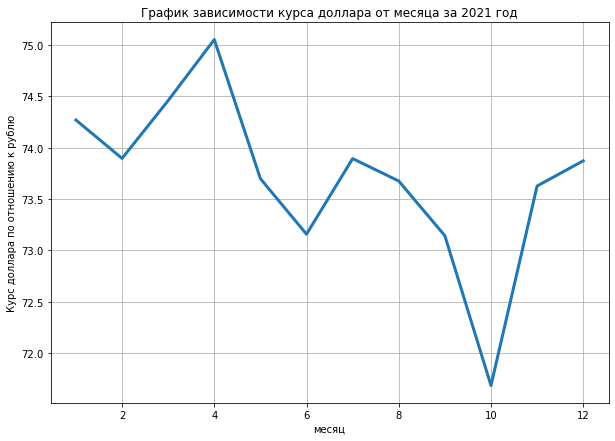

In [72]:
data_rub_grouped.plot(grid=True, linewidth=3, figsize=(10,7), xlabel='месяц', ylabel='Курс доллара по отношению к рублю')
plt.title('График зависимости курса доллара от месяца за 2021 год')
plt.show()

In [73]:
data_bgd_grouped_rub = pd.DataFrame(columns=['mean_price', 'mean_usd/rub'], index=range(1,13))
data_bgd_grouped_rub['mean_price'] = pd.Series(data_bgd_grouped)
data_bgd_grouped_rub['mean_usd/rub'] = pd.Series(data_rub_grouped)
data_bgd_grouped_rub

,mean_price,mean_usd/rub
1,4.113352e+06,74.270468
2,4.119312e+06,73.896332
3,4.018506e+06,74.460285
4,4.126515e+06,75.054233
5,4.176718e+06,73.699350
6,4.199727e+06,73.157614
7,4.254155e+06,73.894357
8,4.328807e+06,73.675895
9,4.470450e+06,73.142817
10,4.641898e+06,71.683205


Найдем коэффициент корреляции Пирсона:

In [74]:
data_bgd_grouped_rub.corr()

,mean_price,mean_usd/rub
mean_price,1.000000,-0.437598
mean_usd/rub,-0.437598,1.000000


**Проследим также была ли взаимосвязь рынка недвижимости с заболеваемостью людей в городе**

In [75]:
covid = pd.read_csv('covid.csv', sep=';', parse_dates=[0], index_col=[0])
covid.head()

,Регион,Заражений,Выздоровлений,Смертей,Смертей за день,Заражений за день,Выздоровлений за день
Дата,,,,,,,
2020-09-20,Томская обл.,6775,5554,79,1,62,92
2020-09-26,Костромская обл.,4553,3329,67,5,54,44
2021-02-09,Ямало-Ненецкий АО,47772,45810,625,4,102,121
2020-12-15,Сахалинская обл.,13406,10292,11,0,142,366
2020-09-21,Волгоградская обл.,14158,12376,131,0,95,13


In [76]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58718 entries, 2020-09-20 to 2021-04-20
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Регион                 58718 non-null  object
 1   Заражений              58718 non-null  int64 
 2   Выздоровлений          58718 non-null  int64 
 3   Смертей                58718 non-null  int64 
 4   Смертей за день        58718 non-null  int64 
 5   Заражений за день      58718 non-null  int64 
 6   Выздоровлений за день  58718 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 3.6+ MB


Сделаем срез для Белгорода:

In [117]:
covid_bgd = covid[(covid['Регион']=='Белгородская обл.') & (covid.index.year==2021)]
covid_bgd.head()

,Регион,Заражений,Выздоровлений,Смертей,Смертей за день,Заражений за день,Выздоровлений за день
Дата,,,,,,,
2021-11-05,Белгородская обл.,37553,34923,654,2,65,35
2021-12-05,Белгородская обл.,37616,34996,656,2,63,73
2021-10-05,Белгородская обл.,37488,34888,652,2,67,29
2021-09-05,Белгородская обл.,37421,34859,650,2,68,17
2021-04-28,Белгородская обл.,36623,34505,627,2,78,131


In [118]:
covid_bgd.shape

(365, 7)

In [119]:
covid_bgd = covid_bgd.sort_values(by='Дата')
covid_bgd.head()

,Регион,Заражений,Выздоровлений,Смертей,Смертей за день,Заражений за день,Выздоровлений за день
Дата,,,,,,,
2021-01-01,Белгородская обл.,22007,20143,262,4,190,170
2021-01-02,Белгородская обл.,27620,24920,375,3,169,78
2021-01-03,Белгородская обл.,31541,28813,487,2,93,25
2021-01-04,Белгородская обл.,34366,32221,565,3,84,189
2021-01-05,Белгородская обл.,36845,34731,633,2,75,97


In [120]:
covid_bgd['месяц'] = covid_bgd.index.month

In [121]:
covid_grouped_good = covid_bgd.groupby(by='месяц')['Выздоровлений'].mean()

In [122]:
covid_grouped_bad = covid_bgd.groupby(by='месяц')['Заражений'].mean()

In [123]:
covid_grouped = pd.DataFrame(columns=['Выздоравлений', 'Заражений'], index=range(1,13))
covid_grouped['Выздоравлений'] = pd.Series(covid_grouped_good)
covid_grouped['Заражений'] = pd.Series(covid_grouped_bad)
covid_grouped

,Выздоравлений,Заражений
1,29485.258065,32497.903226
2,32692.107143,35993.964286
3,34338.322581,37301.741935
4,36214.633333,39052.933333
5,37184.741935,40336.612903
6,38712.300000,41634.500000
7,40310.322581,43585.516129
8,42519.741935,46392.516129
9,44990.100000,49162.933333
10,48107.000000,53690.548387


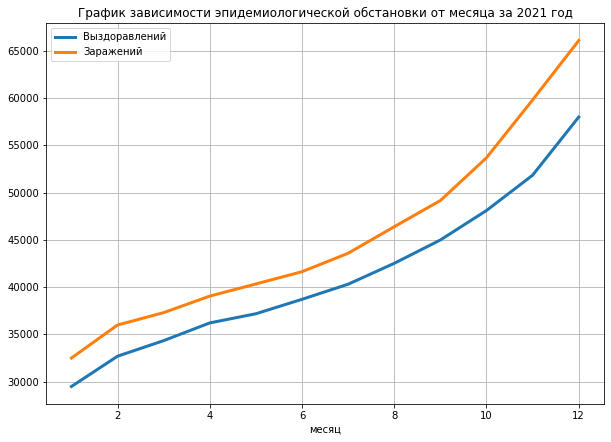

In [124]:
covid_grouped.plot(grid=True, linewidth=3, figsize=(10,7), xlabel='месяц')
plt.title('График зависимости эпидемиологической обстановки от месяца за 2021 год')
plt.show()

In [85]:
covid_grouped['Среднемесячная цена на недвижимость'] = pd.Series(data_bgd_grouped, index=covid_grouped.index)
covid_grouped

,Выздоравлений,Заражений,Среднемесячная цена на недвижимость
1,29485.258065,32497.903226,4.113352e+06
2,32692.107143,35993.964286,4.119312e+06
3,34338.322581,37301.741935,4.018506e+06
4,36214.633333,39052.933333,4.126515e+06
5,37184.741935,40336.612903,4.176718e+06
6,38712.300000,41634.500000,4.199727e+06
7,40310.322581,43585.516129,4.254155e+06
8,42519.741935,46392.516129,4.328807e+06
9,44990.100000,49162.933333,4.470450e+06
10,48107.000000,53690.548387,4.641898e+06


Найдем коэффициенты корреляции Пирсона:

In [86]:
covid_grouped.corr()

,Выздоравлений,Заражений,Среднемесячная цена на недвижимость
Выздоравлений,1.000000,0.996799,0.964690
Заражений,0.996799,1.000000,0.979052
Среднемесячная цена на недвижимость,0.964690,0.979052,1.000000


**Вывод**

Изучая зависимость средней цены на недвижимость в Белгороде от даты за 2021 год мы пришли к выводу, что цена в течение всего года постоянно росла. Такой рост цен на недвижимость нетипичен и мы предположили, что он связан с какими-то внешними факторами.

Одним из факторов влияния на рост цен является курс доллара по отношению к рубля. Мы импортировали данные курса доллара за 2021 год, построили график изменения его среднемесячной цены. Далее мы вычислили коэффициент корреляции Пирсона между курсом доллара и стоимостью недвижимости. Он равен -0.44 

Таким образом, можно утверждать что есть обратная связь между курсом доллара и стоимостью на недвижимость.

Также было предположение о том, что рост цен на недвижимость связан с уровнем заболеваемости в городе. Мы выгрузили официальную статистику заболеваемости и сгрупировали данные по месяцам. Исходя из полученных графиков и вычисленных коэффициентов корреляции Пирсона можно сделать вывод о том что в 2021 году на рост цен недвижимости очень сильно влиял фактор заболеваемости людей в городе. Объясняется это тем, что люди вкладывали деньги, боясь что экономика рухнет в ковидный год. Многие ещё помнят, как деньги горели в 1990-е». Молодые семьи, подстегнул рекордно низкий ипотечный процент и повышенный маткапитал. А поскольку рос спрос, росла и цена.

### Изучим предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выясним, какая область входит в центр.

Создадим столбец с расстоянием до центра в километрах: округлим до целых значений. 

После этого посчитаем среднюю цену для каждого километра. Построим график: он должен показывать, как цена зависит от удалённости от центра. 

Определите границу, где график сильно меняется, — это и будет центральная зона.

Построим график зависимости цен на жилье в зависимости от удаленности от центра города:

In [87]:
data_bgd_grouped = data_bgd.groupby('round_distance_to_center')['price'].mean()
data_bgd_grouped

round_distance_to_center
0     4.591687e+06
1     5.480406e+06
2     4.307578e+06
3     4.306297e+06
4     4.373585e+06
5     4.055484e+06
6     3.841269e+06
7     3.611749e+06
8     3.193361e+06
9     3.828811e+06
10    3.788744e+06
11    3.224975e+06
12    3.358185e+06
13    3.249509e+06
14    2.335484e+06
15    3.623580e+06
16    3.531649e+06
17    3.714219e+06
19    4.420000e+06
22    1.889667e+06
Name: price, dtype: float64

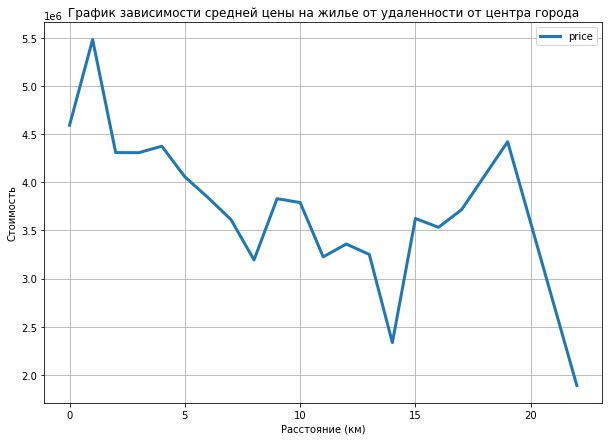

In [88]:
data_bgd_grouped.plot(grid=True, linewidth=3, legend=True, title='price_per_km', figsize=(10,7), xlabel='Расстояние (км)', ylabel='Стоимость')
plt.title('График зависимости средней цены на жилье от удаленности от центра города')
plt.show()

**Вывод**

Для всех объявлений Белгорода мы рассчитали среднюю цену в зависимости от удаленности от центра города. График показывает что происходит резкое изменение цены в районе 3-4 километров от центра. Далее есть резкий рост на 16-18 километрах, который может быть связан с перспективными частными секторами.

## Моделирование

В этом разделе мы будем создавать модель машинного обучения, для прогнозирования цен на недвижимость в Белгороде.

Поскольку будет решаться задача регрессии мы будем использовать как классические модели машинного обуччения, такие модели как линейная регрессия, решающее дерево, случайный лес, так и современные как градиентный бустинг.

### Подготовка данных

Поскольку для обучения моделей мы будем использовать кросс-валидацию, то данные разделим только на тренировочную и тестовую выборки.

In [89]:
data_bgd.columns

Index(['date', 'price', 'level', 'levels', 'rooms', 'area', 'kitchen_area',
       'latitude', 'longitude', 'building_type', 'object_type', 'postal_code',
       'street_id', 'region', 'house_id', 'price_per_meter',
       'ratio_kitchen_total_area', 'distance_to_center',
       'round_distance_to_center', 'month_of_sale', 'day_of_week',
       'category_level'],
      dtype='object')

In [90]:
features = data_bgd.drop(['date', 'price', 'latitude', 'longitude', 'postal_code', 
                          'street_id', 'region', 'house_id', 'round_distance_to_center'], axis=1)
target = data_bgd['price']

In [91]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=27)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(42637, 13)
(42637,)
(10660, 13)
(10660,)


In [92]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

### Линейная регрессия

Линейная регрессия основана на подборе коэффициентов, поэтому первоначально необходимо преобразовать все категориальные признаки в числа.

In [209]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_train_ohe.shape

(42637, 19)

In [210]:
model = LinearRegression()

scores = cross_val_score(model, features_train_ohe, target_train, cv=5, scoring=mse_scorer) 
final_rmse = (np.abs(scores.mean())) ** 0.5
print('rmse_cross_valid:', final_rmse)

rmse_cross_valid: 452143.4274535102


### Дерево решений

In [211]:
model = DecisionTreeRegressor()

params = {
    'max_depth': range(1, 30),
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3]
}

grid = GridSearchCV(model, params, scoring=mse_scorer)
grid.fit(features_train_ohe, target_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 30),
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [212]:
grid.best_params_

{'max_depth': 28, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [213]:
final_rmse = (np.abs(grid.best_score_)) ** 0.5
print('rmse_cross_valid:', final_rmse)

rmse_cross_valid: 175756.93750416907


### Случайный лес

In [214]:
model = RandomForestRegressor()

params = {
    'n_estimators': range(10, 100, 10),
    'max_depth': range(1, 10)
    
}

grid = GridSearchCV(model, params, scoring=mse_scorer)
grid.fit(features_train_ohe, target_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(10, 100, 10)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [215]:
grid.best_params_

{'max_depth': 9, 'n_estimators': 20}

In [216]:
final_rmse = (np.abs(grid.best_score_)) ** 0.5
print('rmse_cross_valid:', final_rmse)

rmse_cross_valid: 171036.53654898156


### CatBoost

In [93]:
features_train.columns

Index(['level', 'levels', 'rooms', 'area', 'kitchen_area', 'building_type',
       'object_type', 'price_per_meter', 'ratio_kitchen_total_area',
       'distance_to_center', 'month_of_sale', 'day_of_week', 'category_level'],
      dtype='object')

In [108]:
params = {}
params['loss_function'] = 'RMSE'
params['iterations'] = 3000
params['random_seed'] = 27
params['learning_rate'] = 0.01
params['eval_metric'] = 'RMSE'
params['custom_metric'] = 'R2'
#params['task_type'] = 'GPU'

cbr_cv_data = cv(
    params = params,
    pool = Pool(features_train, label=target_train, cat_features=['level', 'levels', 'rooms', 'building_type', 'object_type', 
                                                                  'month_of_sale', 'day_of_week', 'category_level']),
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 0,
    plot = True,
    verbose = False,
    early_stopping_rounds = 100
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 109767.3921
bestIteration = 2991

Training on fold [1/5]

bestTest = 254115.7529
bestIteration = 2984

Training on fold [2/5]

bestTest = 229135.0764
bestIteration = 2986

Training on fold [3/5]

bestTest = 132323.7888
bestIteration = 1865

Training on fold [4/5]

bestTest = 93703.89487
bestIteration = 2992



In [109]:
cbr_cv_data.head()

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std,test-R2-mean,test-R2-std,train-R2-mean,train-R2-std
0,0,4.623362e+06,30239.741494,4.623435e+06,7525.433821,-6.122592,0.275712,-6.111736,0.068419
1,1,4.579328e+06,30231.628521,4.579356e+06,7397.875511,-5.987541,0.269933,-5.976779,0.067025
2,2,4.535353e+06,30037.922474,4.535377e+06,7342.477421,-5.853980,0.264641,-5.843415,0.065690
3,3,4.492201e+06,29797.487220,4.492231e+06,7283.111250,-5.724163,0.259324,-5.713828,0.064398
4,4,4.448902e+06,29643.822471,4.448924e+06,7231.144844,-5.595147,0.253869,-5.585002,0.063119


In [113]:
best_value = np.min(cbr_cv_data['test-RMSE-mean'])
best_iter = np.argmin(cbr_cv_data['test-RMSE-mean'])
best_r2 = cbr_cv_data.loc[best_iter, 'test-R2-mean']
print('Лучшее значение RMSE =', best_value)
print('Лучшее значение R2 =', best_r2)
print('лучшая итерация -', best_iter)

Лучшее значение RMSE = 163824.37280686465
Лучшее значение R2 = 0.9898468470462116
лучшая итерация - 2991


In [115]:
cbr_cv_data.loc[best_iter]

iterations           2991.000000
test-RMSE-mean     163824.372807
test-RMSE-std       72882.091479
train-RMSE-mean     70867.568723
train-RMSE-std      10789.176224
test-R2-mean            0.989847
test-R2-std             0.008133
train-R2-mean           0.998299
train-R2-std            0.000525
Name: 2991, dtype: float64

## Тест

In [133]:
model = CatBoostRegressor(loss_function = 'RMSE', iterations=2991, learning_rate=0.01)

model.fit(features_train, target_train, cat_features=['level', 'levels', 'rooms', 'building_type', 'object_type', 'month_of_sale', 'day_of_week', 'category_level'], 
          plot = True, verbose = False)

predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions) ** 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [134]:
print(f'RMSE = {rmse}')

RMSE = 122276.71544055211
